In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit

#LSTM
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

#PCA
from sklearn.decomposition import PCA

#Seaborn
import seaborn as sns


In [2]:
import optuna

file_path = '../feature_engineered_data.csv'  # <-- แก้เอง

# Use existing df_all in the notebook if available, otherwise read CSV
if 'df_all' in globals():
    df_all_local = df_all.copy()
    print("Using existing df_all from notebook variables")
else:
    df_all_local = pd.read_csv(file_path)
    print(f"Loaded df_all from {file_path}")

# If the dataset is in long format (date_month, ind_code, value) pivot to wide.
# If it's already wide (like the provided cleaned_data2.csv), skip pivot.
if 'ind_code' in df_all_local.columns and 'value' in df_all_local.columns:
    # ensure date column name matches expectation
    if 'date_month' not in df_all_local.columns and 'year_month' in df_all_local.columns:
        df_all_local = df_all_local.rename(columns={'year_month': 'date_month'})
    # ลบ whitespace จาก ind_code
    df_all_local['ind_code'] = df_all_local['ind_code'].astype(str).str.strip()

    print("Available indicators:")
    print(sorted(df_all_local['ind_code'].unique()))
    print()

    df = df_all_local.pivot_table(
        index='date_month',
        columns='ind_code',
        values='value'
    ).reset_index()
else:
    # assume wide format; try to find date column
    if 'date_month' in df_all_local.columns:
        df = df_all_local.copy()
        date_col = 'date_month'
    elif 'year_month' in df_all_local.columns:
        df = df_all_local.copy().rename(columns={'year_month': 'date_month'})
        date_col = 'date_month'
    else:
        raise KeyError("No 'ind_code' column and no recognized date column ('date_month' or 'year_month') found in df_all.")

    print(f"Data treated as wide format. Columns: {sorted(df.columns.tolist())}\n")

print(f"Data loaded: {df.shape}")

# เตรียมข้อมูล
df['date_month'] = pd.to_datetime(df['date_month'], infer_datetime_format=True)
df = df.set_index(['date_month']).sort_index()
df = df.asfreq('MS')  # ตั้งความถี่เป็น Monthly Start

print("Data preparation completed\n")
df.info()

test_size = 18
train_data = df[:-test_size]
test_data = df[-test_size:]

print("\nTrain data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

df

Loaded df_all from ../feature_engineered_data.csv
Data treated as wide format. Columns: ['china_pmi', 'china_pmi_lag1', 'china_pmi_lag12', 'china_pmi_lag3', 'china_pmi_lag6', 'china_pmi_ma12', 'china_pmi_ma3', 'china_pmi_ma6', 'china_pmi_std12', 'china_pmi_std3', 'china_pmi_std6', 'date_month', 'domestic_consumption', 'exchange_rate_usd', 'exchange_rate_usd_lag1', 'exchange_rate_usd_lag12', 'exchange_rate_usd_lag3', 'exchange_rate_usd_lag6', 'exchange_rate_usd_pct1', 'exchange_rate_usd_pct12', 'exchange_rate_usd_pct3', 'exchange_rate_usd_pct6', 'export_volume', 'import_volume', 'is_season', 'month', 'net_export', 'net_export_lag1', 'net_export_lag12', 'net_export_lag3', 'net_export_lag6', 'oil_price_thb', 'oil_price_thb_lag1', 'oil_price_thb_lag12', 'oil_price_thb_lag3', 'oil_price_thb_lag6', 'oil_price_thb_ma12', 'oil_price_thb_ma3', 'oil_price_thb_ma6', 'oil_price_thb_pct1', 'oil_price_thb_pct12', 'oil_price_thb_pct3', 'oil_price_thb_pct6', 'oil_price_thb_std12', 'oil_price_thb_std3'

c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\bankw\AppData\Local\Temp\ipykernel_29916\2100898711.py:47: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['date_month'] = pd.to_datetime(df['date_month'], infer_datetime_format=True)


thai_production  domestic_consumption  import_volume  \
date_month                                                         
2007-01-01        328940000              30652000          55000   
2007-02-01        267868000              26790000          44000   
2007-03-01        246813000              31717000         119000   
2007-04-01        165458000              27788000         184000   
2007-05-01        172153000              32905000          91000   
...                     ...                   ...            ...   
2025-02-01        578922000             109368000          63000   
2025-03-01        413728000              95398000         111000   
2025-04-01        267722000              69306000          73000   
2025-05-01        416062000              90856000         123000   
2025-06-01        339807000              86959000          43000   

            export_volume         stock  exchange_rate_usd  china_pmi  \
date_month                                                              
2007-01-01    267567000.0  2.806710e+08            36.1800       54.8   
2007-02-01    237979000.0  2.490050e+08            35.7500       55.1   
2007-03-01    230410000.0  2.173390e+08            35.0600       53.1   
2007-04-01    180185000.0  1.785750e+08            34.8700       56.1   
2007-05-01    178103000.0  2.092150e+08            34.6200       58.6   
...                   ...           ...                ...        ...   
2025-02-01    369222000.0  1.050152e+09            33.9385       50.2   
2025-03-01    369396000.0  9.991970e+08            33.9768       50.5   
2025-04-01    317716000.0  8.799700e+08            33.9148       49.0   
2025-05-01    360478000.0  8.448210e+08            33.1076       49.5   
2025-06-01    269128000.0  8.285830e+08            32.7844       49.7   

            thai_price  oil_price_thb  world_price_thb_kg  ...  \
date_month                                                 ...   
2007-01-01       65.12    2103.505200           75.168260  ...   
2007-02-01       72.91    2208.992500           81.465325  ...   
2007-03-01       69.62    2309.402200           78.626062  ...   
2007-04-01       72.84    2291.307700           80.907121  ...   
2007-05-01       71.47    2216.026200           82.004049  ...   
...                ...            ...                 ...  ...   
2025-02-01       67.91    2367.549760           82.482469  ...   
2025-03-01       66.56    2428.661664           81.367993  ...   
2025-04-01       59.69    1974.180508           73.920391  ...   
2025-05-01       64.05    2012.611004           73.778769  ...   
2025-06-01       60.94    2134.592284           72.294274  ...   

            supply_demand_balance_lag6  supply_demand_balance_lag12  \
date_month                                                            
2007-01-01                1.099201e+06                 9.458738e+05   
2007-02-01                1.099201e+06                 9.458738e+05   
2007-03-01                1.099201e+06                 9.458738e+05   
2007-04-01                1.099201e+06                 9.458738e+05   
2007-05-01                1.099201e+06                 9.458738e+05   
...                                ...                          ...   
2025-02-01               -5.545600e+07                 2.516900e+07   
2025-03-01                1.950000e+06                -5.163000e+07   
2025-04-01               -2.167300e+07                -5.963100e+07   
2025-05-01               -2.621700e+07                 1.288600e+07   
2025-06-01                1.197610e+08                -1.966500e+07   

            stock_consumption_ratio_lag1  stock_consumption_ratio_lag3  \
date_month                                                               
2007-01-01                     10.272641                     10.266019   
2007-02-01                      9.156695                     10.266019   
2007-03-01                      9.294700                     10.266019   
2007-04-01              

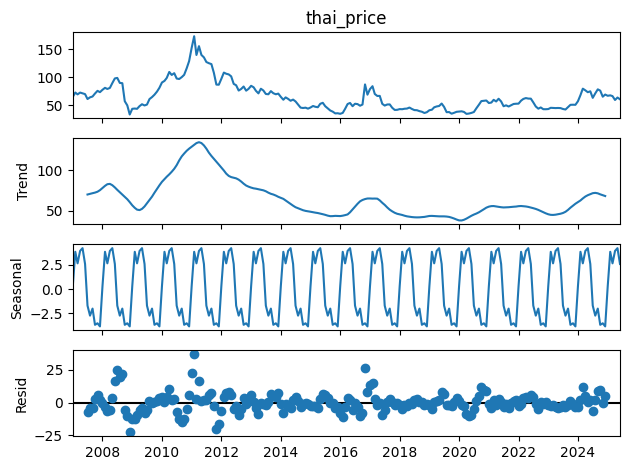

In [3]:
result = seasonal_decompose(df['thai_price'], model='additive', period=12)
result.plot()
plt.show()

Available columns: ['thai_production', 'domestic_consumption', 'import_volume', 'export_volume', 'stock', 'exchange_rate_usd', 'china_pmi', 'thai_price', 'oil_price_thb', 'world_price_thb_kg', 'month', 'quarter', 'year', 'is_season', 'thai_price_ma3', 'thai_price_std3', 'thai_price_ma6', 'thai_price_std6', 'thai_price_ma12', 'thai_price_std12', 'world_price_thb_kg_ma3', 'world_price_thb_kg_std3', 'world_price_thb_kg_ma6', 'world_price_thb_kg_std6', 'world_price_thb_kg_ma12', 'world_price_thb_kg_std12', 'oil_price_thb_ma3', 'oil_price_thb_std3', 'oil_price_thb_ma6', 'oil_price_thb_std6', 'oil_price_thb_ma12', 'oil_price_thb_std12', 'china_pmi_ma3', 'china_pmi_std3', 'china_pmi_ma6', 'china_pmi_std6', 'china_pmi_ma12', 'china_pmi_std12', 'thai_price_pct1', 'thai_price_pct3', 'thai_price_pct6', 'thai_price_pct12', 'world_price_thb_kg_pct1', 'world_price_thb_kg_pct3', 'world_price_thb_kg_pct6', 'world_price_thb_kg_pct12', 'oil_price_thb_pct1', 'oil_price_thb_pct3', 'oil_price_thb_pct6', 'o

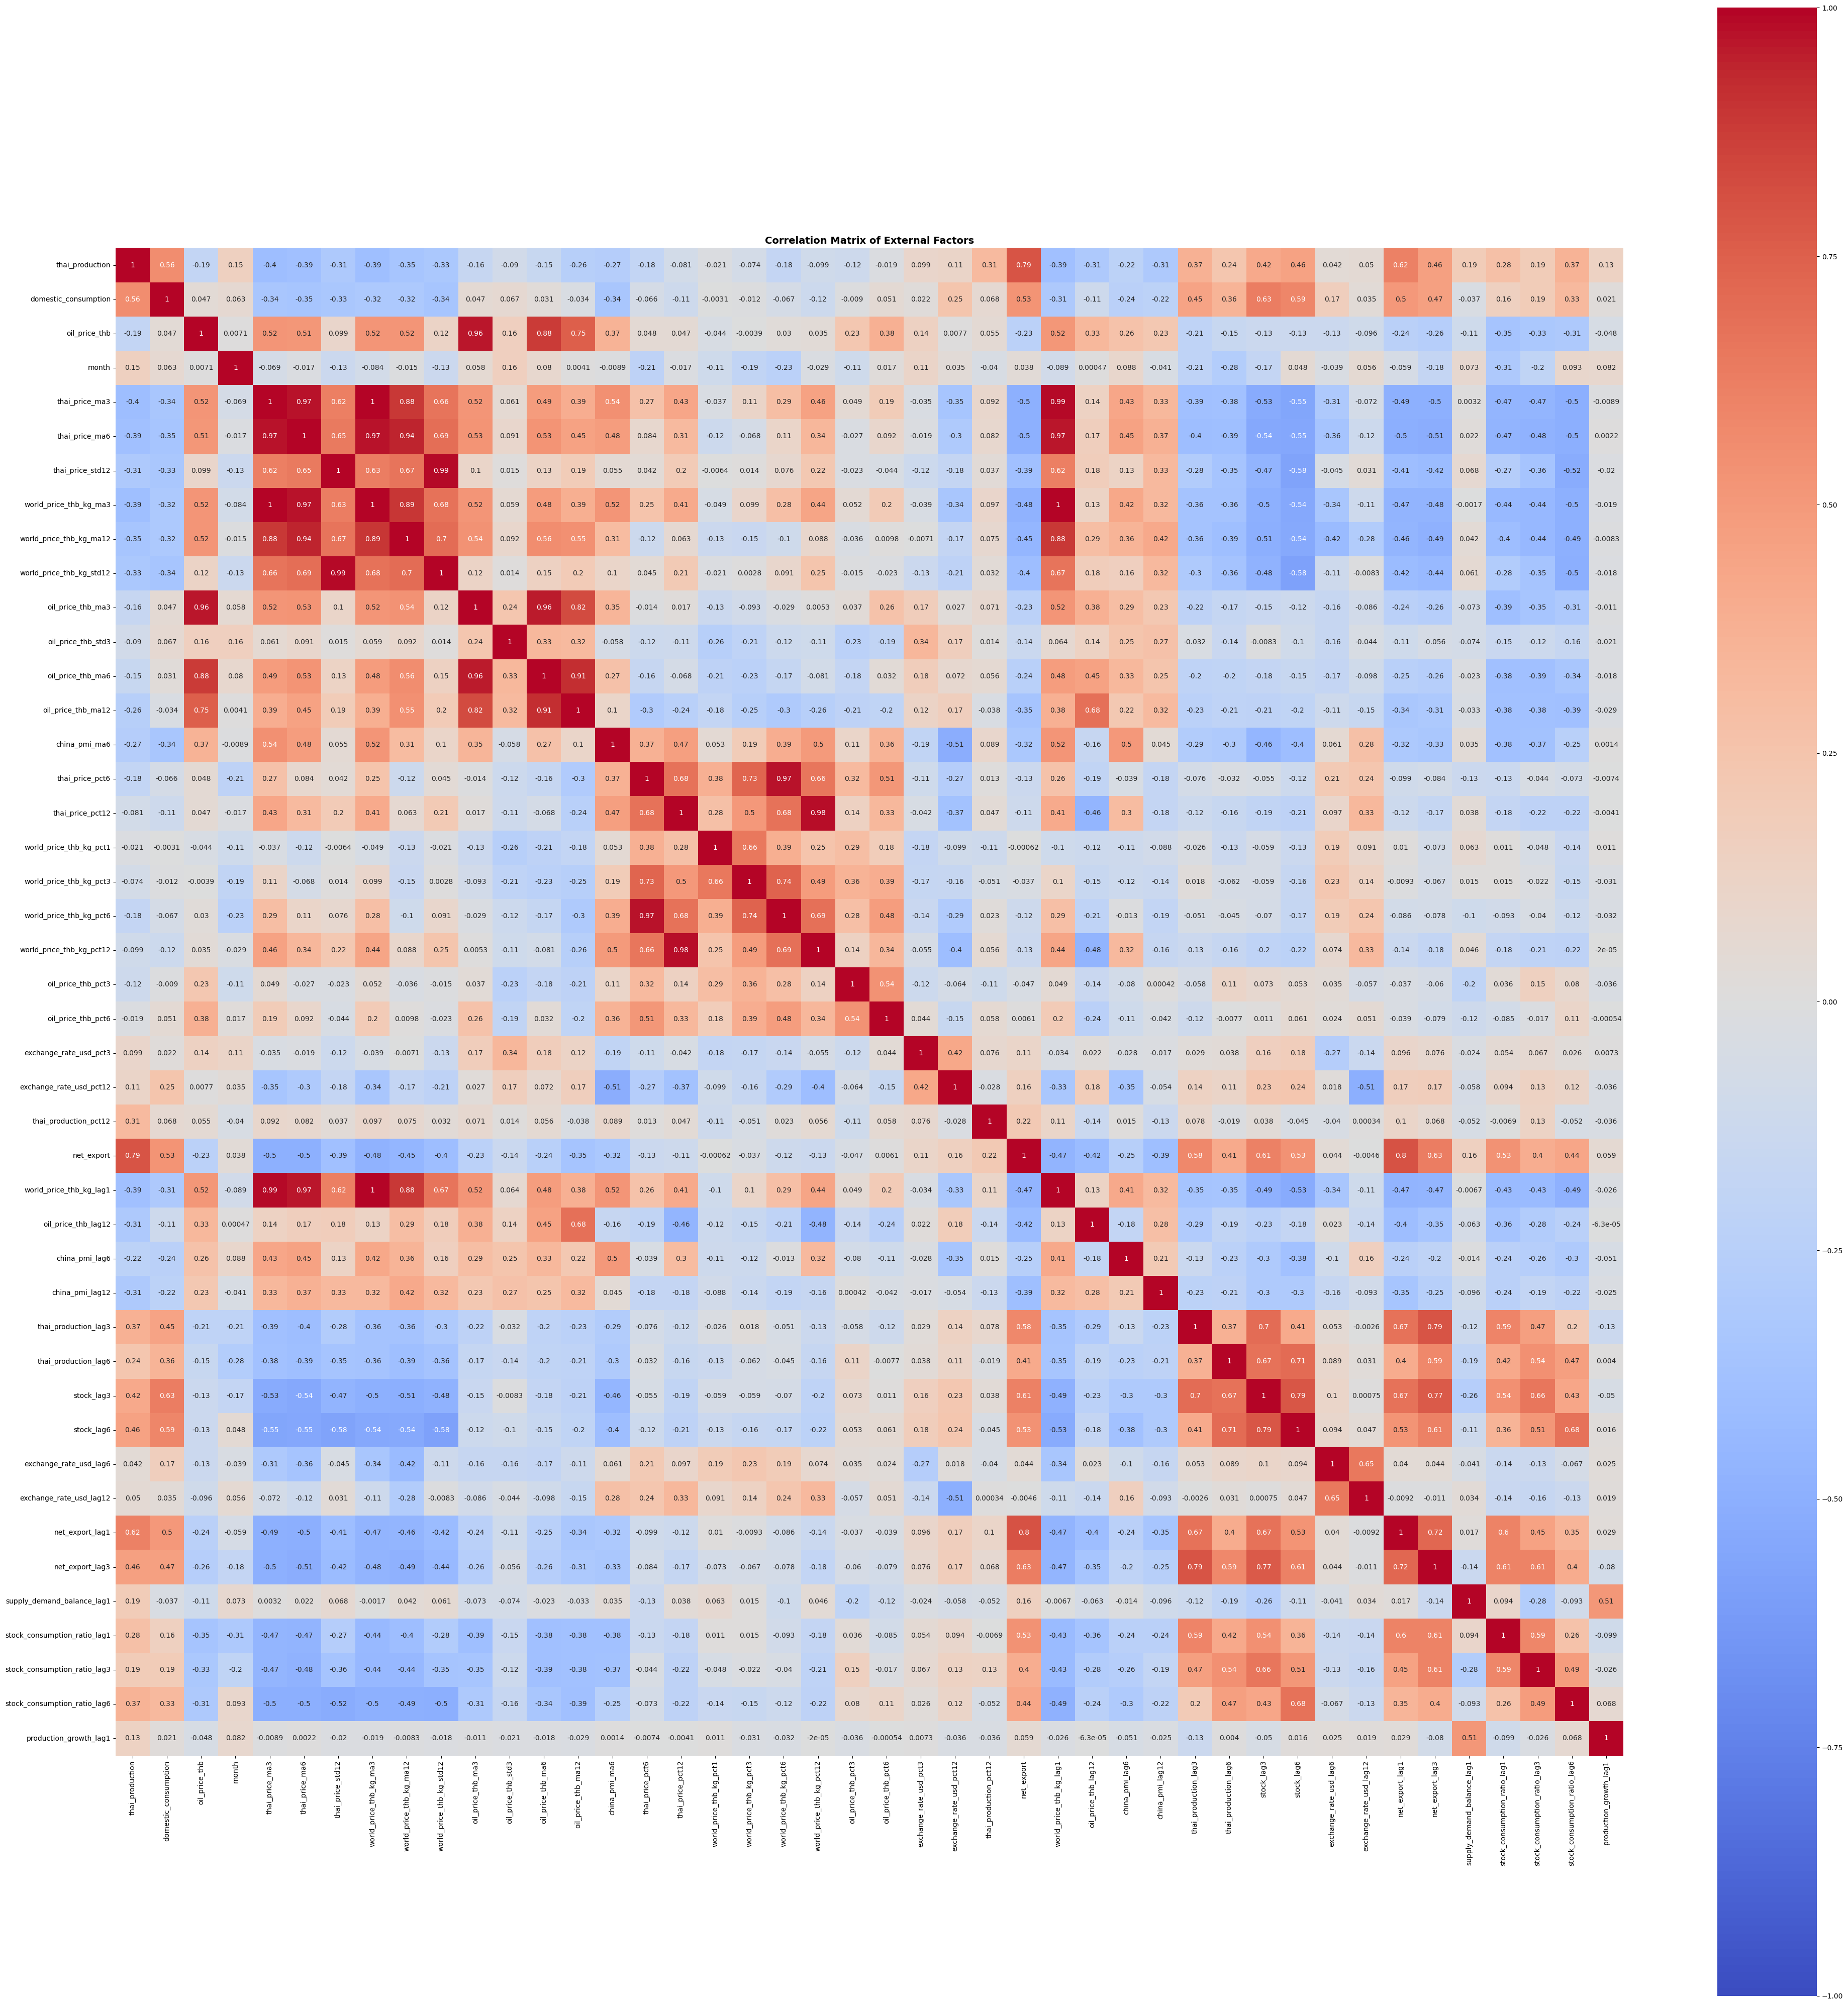

In [20]:
external_factors = [
    'thai_production',
'domestic_consumption',
'oil_price_thb',
'month',
'thai_price_ma3',
'thai_price_ma6',
'thai_price_std12',
'world_price_thb_kg_ma3',
'world_price_thb_kg_ma12',
'world_price_thb_kg_std12',
'oil_price_thb_ma3',
'oil_price_thb_std3',
'oil_price_thb_ma6',
'oil_price_thb_ma12',
'china_pmi_ma6',
'thai_price_pct6',
'thai_price_pct12',
'world_price_thb_kg_pct1',
'world_price_thb_kg_pct3',
'world_price_thb_kg_pct6',
'world_price_thb_kg_pct12',
'oil_price_thb_pct3',
'oil_price_thb_pct6',
'exchange_rate_usd_pct3',
'exchange_rate_usd_pct12',
'thai_production_pct12',
'net_export',
'world_price_thb_kg_lag1',
'oil_price_thb_lag12',
'china_pmi_lag6',
'china_pmi_lag12',
'thai_production_lag3',
'thai_production_lag6',
'stock_lag3',
'stock_lag6',
'exchange_rate_usd_lag6',
'exchange_rate_usd_lag12',
'net_export_lag1',
'net_export_lag3',
'supply_demand_balance_lag1',
'stock_consumption_ratio_lag1',
'stock_consumption_ratio_lag3',
'stock_consumption_ratio_lag6',
'production_growth_lag1',
]

print("Available columns:", df.columns.tolist())
print("Selected external factors:", [c for c in external_factors if c in df.columns])
print()

# เตรียม X, y
train_exog = train_data[external_factors].copy()
test_exog  = test_data[external_factors].copy()

X_train = train_exog.copy()
X_test  = test_exog.copy()
y_train = train_data['thai_price']
y_test  = test_data['thai_price']

mean_trp = y_train.mean()
print(f"Mean thai_price (train): {mean_trp:.4f}")
print("X_train:", X_train.shape, " X_test:", X_test.shape)

# Correlation matrix ของ external factors
corr = train_exog.corr()

plt.figure(figsize=(40, 40))
sns.heatmap(
    corr,
    annot=True,
    cmap='coolwarm',
    vmin=-1, vmax=1,
    square=True
)
plt.title("Correlation Matrix of External Factors", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


In [5]:
full_train = train_data[['thai_price'] + external_factors].copy()
full_test  = test_data[['thai_price'] + external_factors].copy()

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(full_train)
test_scaled  = scaler.transform(full_test)

WINDOW = 12

def create_seq(data, win=WINDOW):
    X, y = [], []
    for i in range(len(data)-win):
        X.append(data[i:i+win, :])
        y.append(data[i+win, 0])
    return np.array(X), np.array(y)


X_train, y_train = create_seq(train_scaled)
X_test, y_test   = create_seq(test_scaled)

print("X_train:", X_train.shape)
print("X_test :", X_test.shape)


X_train: (192, 12, 45)
X_test : (6, 12, 45)


In [6]:
model = Sequential([
    LSTM(64, activation='tanh', return_sequences=False,
         input_shape=(WINDOW, X_train.shape[2])),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()


c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        28,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,273 (118.25 KB)

 Trainable params: 30,273 (118.25 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
es = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=16,
    callbacks=[es],
    verbose=1
)


Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.1189 - val_loss: 0.0102
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0286 - val_loss: 0.0104
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0152 - val_loss: 0.0019
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0162 - val_loss: 0.0016
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0166 - val_loss: 0.0031
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0157 - val_loss: 9.6870e-04
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0086 - val_loss: 0.0024
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0072 - val_loss: 0.0027
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0086 - val_loss: 0.0014
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0086 - val_loss: 0.0010
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0067 - val_loss: 9.3537e-04
Epoch 12/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step -

In [8]:
pred_scaled = model.predict(X_test)

dummy = np.zeros((len(pred_scaled), train_scaled.shape[1]))
dummy[:,0] = pred_scaled[:,0]

pred = scaler.inverse_transform(dummy)[:,0]
actual = test_data['thai_price'].iloc[WINDOW:].values

rmse_before = np.sqrt(mean_squared_error(actual, pred))
mape_before = mean_absolute_percentage_error(actual, pred)*100

print("=== BEFORE MODEL (Baseline LSTM) ===")
print(f"RMSE : {rmse_before:.4f}")
print(f"MAPE : {mape_before:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
=== BEFORE MODEL (Baseline LSTM) ===
RMSE : 11.6359
MAPE : 16.26%


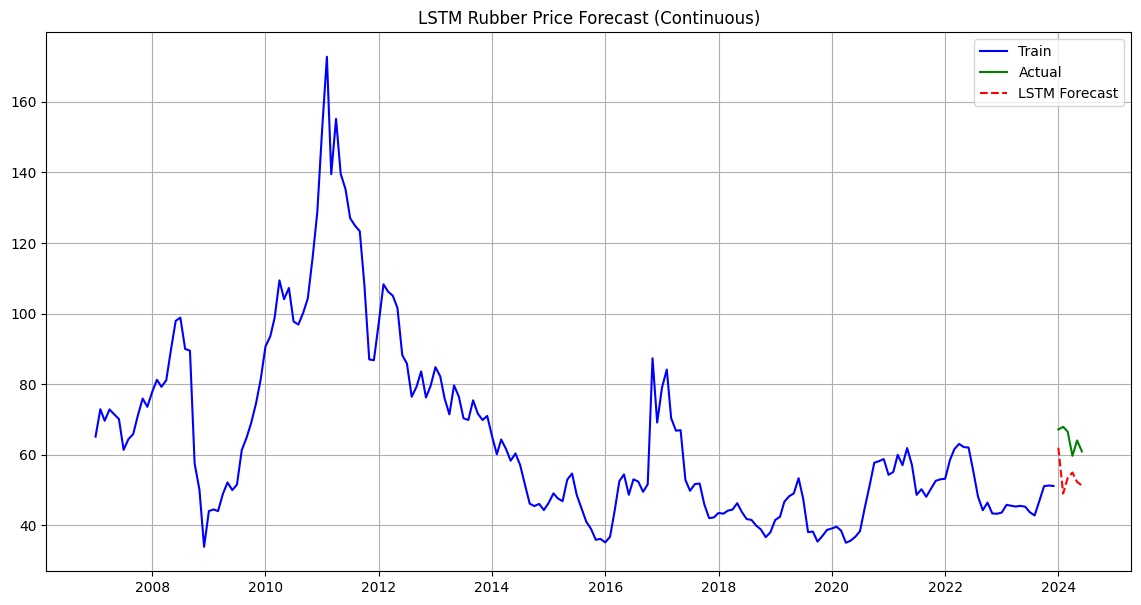

C:\Users\bankw\AppData\Local\Temp\ipykernel_29916\3748362943.py:57: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 0.85, 0.96])


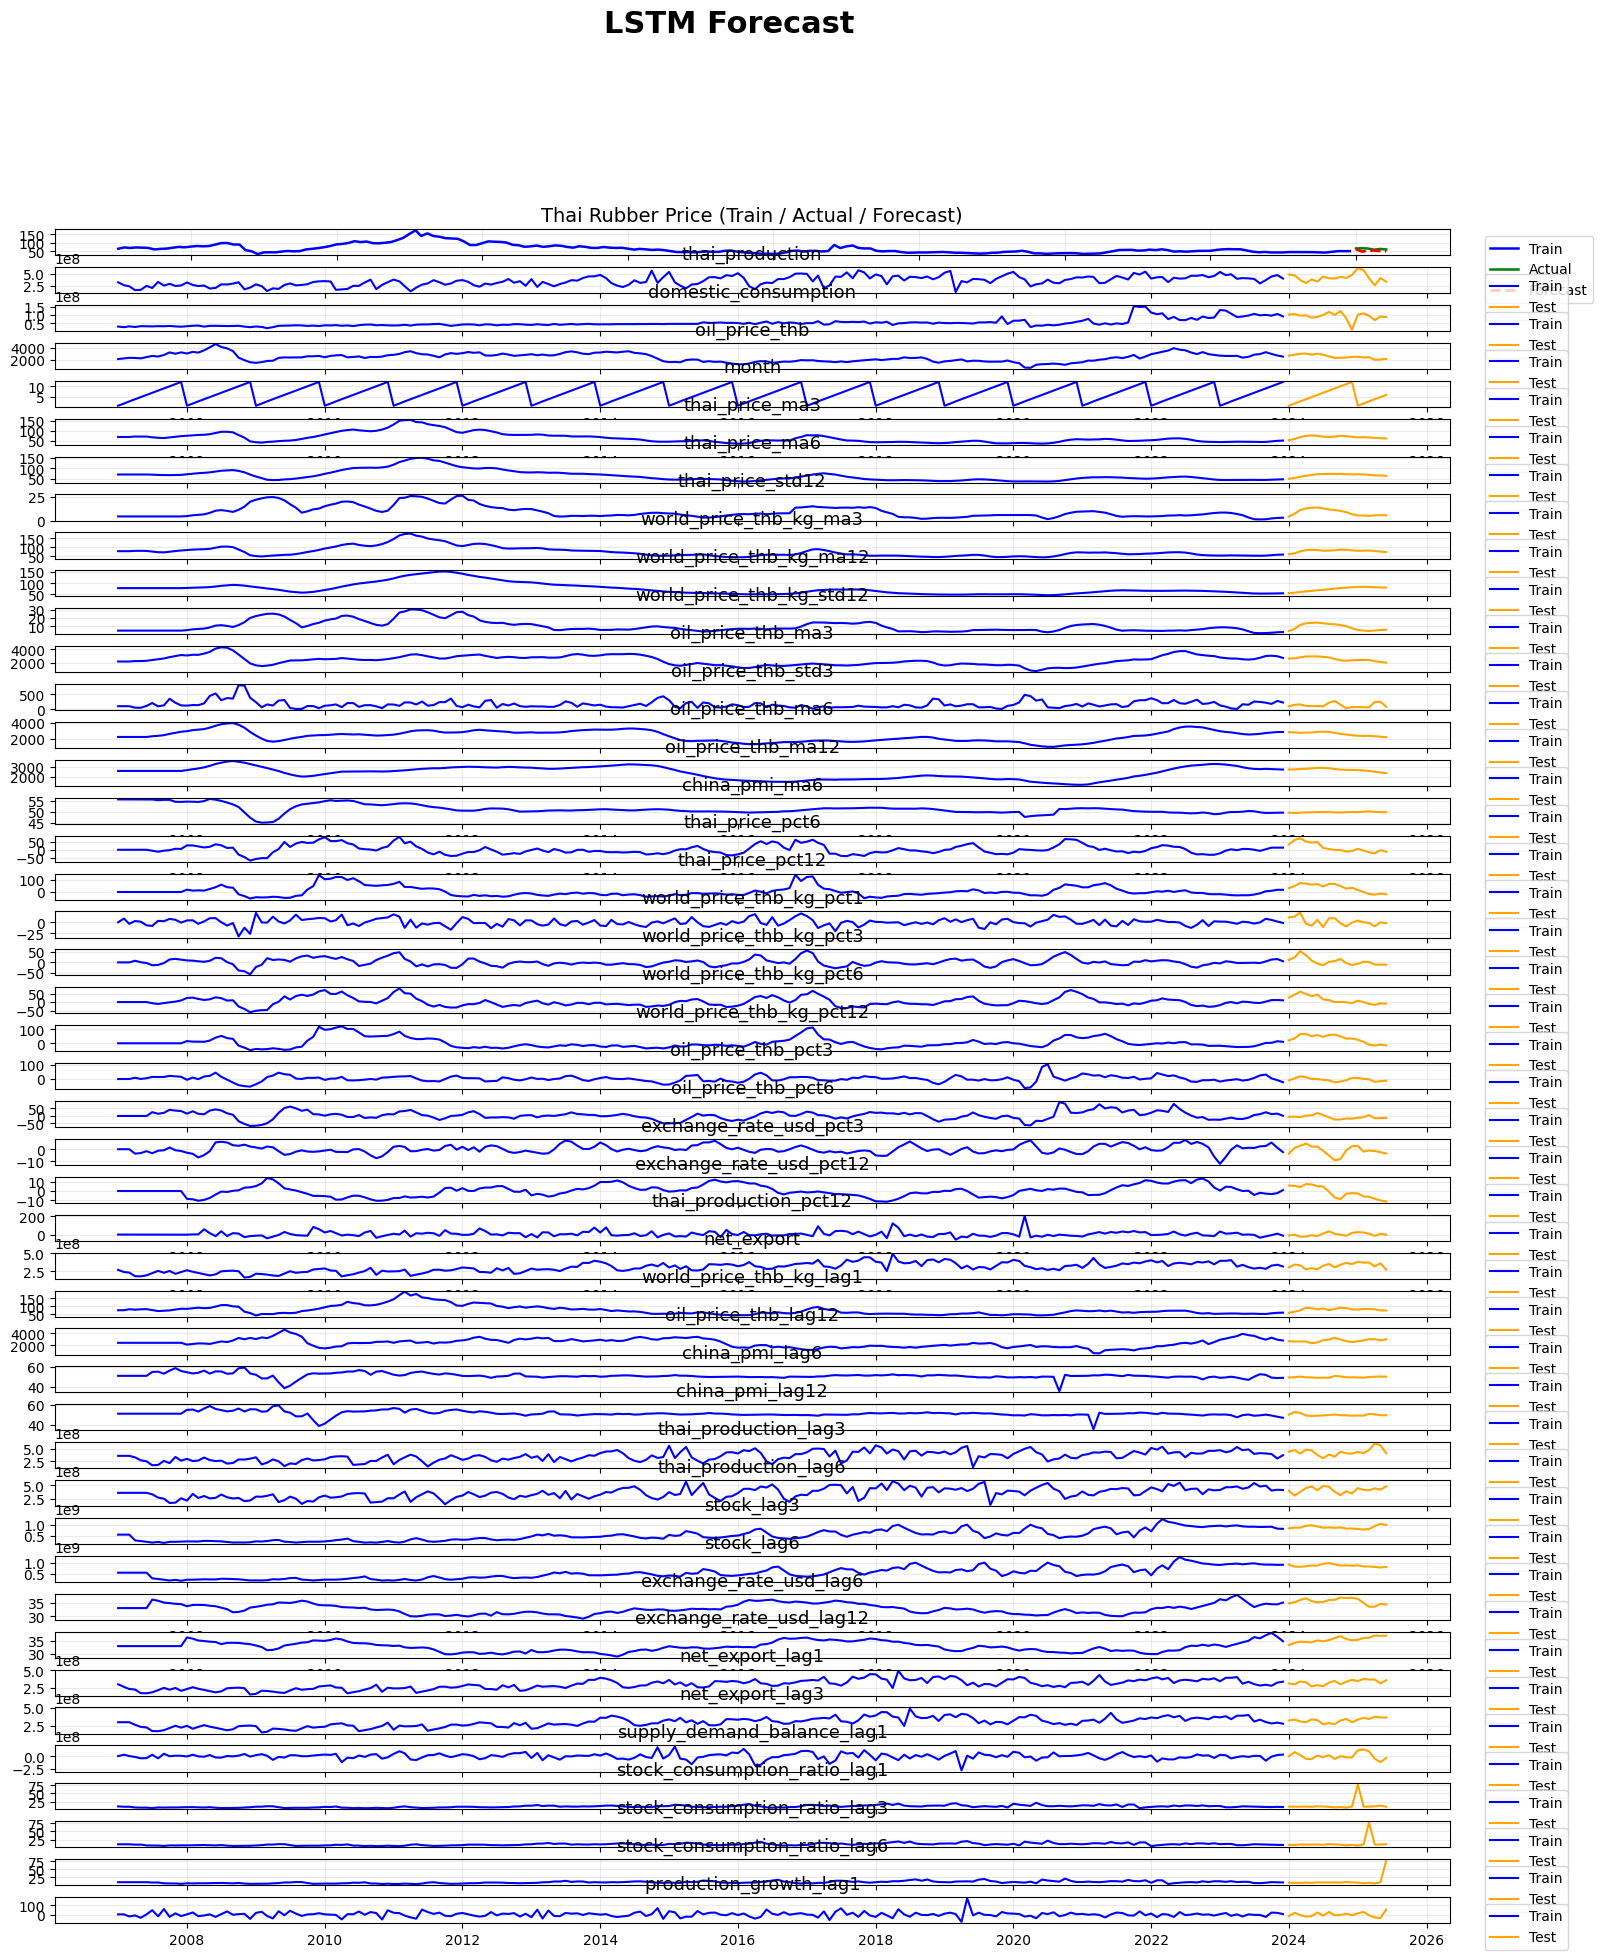

In [9]:
pred_index = pd.date_range(
    start=train_data.index[-1] + pd.offsets.MonthBegin(1),
    periods=len(pred),
    freq='MS'
)

plt.figure(figsize=(14,7))

plt.plot(train_data.index, train_data['thai_price'], label='Train', color='blue')

plt.plot(test_data.index[:len(actual)], actual, label='Actual', color='green')

plt.plot(pred_index, pred, label='LSTM Forecast', color='red', linestyle='--')

plt.title("LSTM Rubber Price Forecast (Continuous)")
plt.grid(True)
plt.legend()
plt.show()



pred_index = pd.date_range(
    start=train_data.index[-1] + pd.offsets.MonthBegin(1),
    periods=len(pred),
    freq='MS'
)


fig, axes = plt.subplots(len(external_factors)+1, 1, figsize=(18, 22))

fig.suptitle("LSTM Forecast", fontsize=22, fontweight='bold')

plt.subplots_adjust(hspace=0.45)

ax0 = axes[0]

ax0.plot(train_data.index, train_data['thai_price'], label='Train', color='blue', linewidth=1.8)
ax0.plot(test_data.index[:len(actual)], actual, color='green', label='Actual', linewidth=1.8)
ax0.plot(pred_index, pred, color='red', label='Forecast', linestyle='--', linewidth=2.0)

ax0.set_title("Thai Rubber Price (Train / Actual / Forecast)", fontsize=14)
ax0.grid(True, alpha=0.25)

ax0.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

for i, fac in enumerate(external_factors):
    ax = axes[i+1]

    ax.plot(train_data.index, train_data[fac], color='blue', label='Train', linewidth=1.5)
    ax.plot(test_data.index, test_data[fac], color='orange', label='Test', linewidth=1.5)

    ax.set_title(fac, fontsize=13)
    ax.grid(True, alpha=0.25)

    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

plt.tight_layout(rect=[0, 0, 0.85, 0.96])
plt.show()



Parameter Optimization (Optuna)

In [10]:
import optuna

def objective_lstm(trial):
    lstm_units = trial.suggest_int('lstm_units', 32, 128)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    dense_units = trial.suggest_int('dense_units', 16, 64)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)

    model = Sequential([
        LSTM(lstm_units, 
             activation='tanh', 
             return_sequences=False,
             input_shape=(WINDOW, X_train.shape[2])
            ),
        Dropout(dropout_rate),
        Dense(dense_units, activation='relu'),
        Dense(1)
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')

    es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        validation_split=0.1,
        epochs=100,
        batch_size=16,
        callbacks=[es],
        verbose=0
    )

    pred_scaled = model.predict(X_test)
    dummy = np.zeros((len(pred_scaled), train_scaled.shape[1]))
    dummy[:,0] = pred_scaled[:,0]
    pred = scaler.inverse_transform(dummy)[:,0]
    actual = test_data['thai_price'].iloc[WINDOW:].values

    rmse = np.sqrt(mean_squared_error(actual, pred))
    return rmse


study_lstm = optuna.create_study(direction='minimize')
study_lstm.optimize(objective_lstm, n_trials=60)

best_lstm_params = study_lstm.best_params
print("\nOPTUNA BEST PARAMS (LSTM)")
print(best_lstm_params)

[I 2025-11-27 22:40:54,162] A new study created in memory with name: no-name-4219c914-8c8a-4e56-b0ec-3118d1d0d9c1
C:\Users\bankw\AppData\Local\Temp\ipykernel_29916\284895127.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


[I 2025-11-27 22:41:02,740] Trial 0 finished with value: 7.514840971445588 and parameters: {'lstm_units': 57, 'dropout_rate': 0.2687467169997354, 'dense_units': 62, 'learning_rate': 0.0013080792915196732}. Best is trial 0 with value: 7.514840971445588.
C:\Users\bankw\AppData\Local\Temp\ipykernel_29916\284895127.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


[I 2025-11-27 22:41:06,880] Trial 1 finished with value: 10.525859178921998 and parameters: {'lstm_units': 97, 'dropout_rate': 0.22715210096965932, 'dense_units': 17, 'learning_rate': 0.00024102002086077843}. Best is trial 0 with value: 7.514840971445588.
C:\Users\bankw\AppData\Local\Temp\ipykernel_29916\284895127.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


[I 2025-11-27 22:41:11,464] Trial 2 finished with value: 8.979388176582003 and parameters: {'lstm_units': 39, 'dropout_rate': 0.2921358577542311, 'dense_units': 58, 'learning_rate': 0.00018582456976060443}. Best is trial 0 with value: 7.514840971445588.
C:\Users\bankw\AppData\Local\Temp\ipykernel_29916\284895127.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


[I 2025-11-27 22:41:18,112] Trial 3 finished with value: 10.009511162383406 and parameters: {'lstm_units': 59, 'dropout_rate': 0.410692662843263, 'dense_units': 62, 'learning_rate': 0.0067604216097690625}. Best is trial 0 with value: 7.514840971445588.
C:\Users\bankw\AppData\Local\Temp\ipykernel_29916\284895127.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


[I 2025-11-27 22:41:26,026] Trial 4 finished with value: 5.446059151045882 and parameters: {'lstm_units': 118, 'dropout_rate': 0.2500284467700585, 'dense_units': 50, 'learning_rate': 0.0008407518329131522}. Best is trial 4 with value: 5.446059151045882.
C:\Users\bankw\AppData\Local\Temp\ipykernel_29916\284895127.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


[I 2025-11-27 22:41:33,345] Trial 5 finished with value: 8.783598014538459 and parameters: {'lstm_units': 61, 'dropout_rate': 0.47257452910280395, 'dense_units': 61, 'learning_rate': 0.0002096930919135811}. Best is trial 4 with value: 5.446059151045882.
C:\Users\bankw\AppData\Local\Temp\ipykernel_29916\284895127.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


[I 2025-11-27 22:41:38,910] Trial 6 finished with value: 4.268063046532819 and parameters: {'lstm_units': 123, 'dropout_rate': 0.4557419276687048, 'dense_units': 40, 'learning_rate': 0.00012253603031856796}. Best is trial 6 with value: 4.268063046532819.
C:\Users\bankw\AppData\Local\Temp\ipykernel_29916\284895127.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


[I 2025-11-27 22:41:45,481] Trial 7 finished with value: 7.378548093610266 and parameters: {'lstm_units': 123, 'dropout_rate': 0.12401220287393283, 'dense_units': 54, 'learning_rate': 0.0030553407662476666}. Best is trial 6 with value: 4.268063046532819.
C:\Users\bankw\AppData\Local\Temp\ipykernel_29916\284895127.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


[I 2025-11-27 22:41:50,939] Trial 8 finished with value: 7.490072625322386 and parameters: {'lstm_units': 86, 'dropout_rate': 0.3196234618262743, 'dense_units': 48, 'learning_rate': 0.0027302730890300156}. Best is trial 6 with value: 4.268063046532819.
C:\Users\bankw\AppData\Local\Temp\ipykernel_29916\284895127.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


[I 2025-11-27 22:41:56,377] Trial 9 finished with value: 14.798969589801109 and parameters: {'lstm_units': 78, 'dropout_rate': 0.432596095550147, 'dense_units': 29, 'learning_rate': 0.0004763498021412775}. Best is trial 6 with value: 4.268063046532819.
C:\Users\bankw\AppData\Local\Temp\ipykernel_29916\284895127.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


[I 2025-11-27 22:42:05,744] Trial 10 finished with value: 18.79191126013927 and parameters: {'lstm_units': 108, 'dropout_rate': 0.3677635323270766, 'dense_units': 35, 'learning_rate': 0.0001114907349278349}. Best is trial 6 with value: 4.268063046532819.
C:\Users\bankw\AppData\Local\Temp\ipykernel_29916\284895127.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


[I 2025-11-27 22:42:10,219] Trial 11 finished with value: 9.280659657986591 and parameters: {'lstm_units': 120, 'dropout_rate': 0.17045313049594932, 'dense_units': 41, 'learning_rate': 0.000659306012393597}. Best is trial 6 with value: 4.268063046532819.
C:\Users\bankw\AppData\Local\Temp\ipykernel_29916\284895127.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


[I 2025-11-27 22:42:13,979] Trial 12 finished with value: 14.095353903793443 and parameters: {'lstm_units': 108, 'dropout_rate': 0.21041708751036003, 'dense_units': 46, 'learning_rate': 0.0010256904141043523}. Best is trial 6 with value: 4.268063046532819.
C:\Users\bankw\AppData\Local\Temp\ipykernel_29916\284895127.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


[I 2025-11-27 22:42:18,399] Trial 13 finished with value: 9.860271484304644 and parameters: {'lstm_units': 127, 'dropout_rate': 0.4964643351133136, 'dense_units': 31, 'learning_rate': 0.0004431063069143908}. Best is trial 6 with value: 4.268063046532819.
C:\Users\bankw\AppData\Local\Temp\ipykernel_29916\284895127.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


[I 2025-11-27 22:42:26,160] Trial 14 finished with value: 6.96498529397057 and parameters: {'lstm_units': 109, 'dropout_rate': 0.36291367040582895, 'dense_units': 50, 'learning_rate': 0.0020061346296146977}. Best is trial 6 with value: 4.268063046532819.
C:\Users\bankw\AppData\Local\Temp\ipykernel_29916\284895127.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


[I 2025-11-27 22:42:29,778] Trial 15 finished with value: 25.02943282526557 and parameters: {'lstm_units': 93, 'dropout_rate': 0.3398495821996024, 'dense_units': 40, 'learning_rate': 0.00010058373353354098}. Best is trial 6 with value: 4.268063046532819.
C:\Users\bankw\AppData\Local\Temp\ipykernel_29916\284895127.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


[I 2025-11-27 22:42:36,798] Trial 16 finished with value: 10.432762535104233 and parameters: {'lstm_units': 115, 'dropout_rate': 0.2511999643219325, 'dense_units': 22, 'learning_rate': 0.007875380867731794}. Best is trial 6 with value: 4.268063046532819.
C:\Users\bankw\AppData\Local\Temp\ipykernel_29916\284895127.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


[I 2025-11-27 22:42:40,915] Trial 17 finished with value: 11.09547117039309 and parameters: {'lstm_units': 75, 'dropout_rate': 0.1783390397689242, 'dense_units': 40, 'learning_rate': 0.0003448910331501836}. Best is trial 6 with value: 4.268063046532819.
C:\Users\bankw\AppData\Local\Temp\ipykernel_29916\284895127.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


[I 2025-11-27 22:42:45,510] Trial 18 finished with value: 6.204325945507557 and parameters: {'lstm_units': 128, 'dropout_rate': 0.40407165059159406, 'dense_units': 54, 'learning_rate': 0.0008853687609621328}. Best is trial 6 with value: 4.268063046532819.
C:\Users\bankw\AppData\Local\Temp\ipykernel_29916\284895127.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


[I 2025-11-27 22:42:50,918] Trial 19 finished with value: 9.13928189903566 and parameters: {'lstm_units': 99, 'dropout_rate': 0.1043190987268657, 'dense_units': 45, 'learning_rate': 0.004261699034306049}. Best is trial 6 with value: 4.268063046532819.
C:\Users\bankw\AppData\Local\Temp\ipykernel_29916\284895127.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


[I 2025-11-27 22:42:53,986] Trial 20 finished with value: 17.743891328712106 and parameters: {'lstm_units': 33, 'dropout_rate': 0.2904865757996653, 'dense_units': 36, 'learning_rate': 0.0015838192505676797}. Best is trial 6 with value: 4.268063046532819.
C:\Users\bankw\AppData\Local\Temp\ipykernel_29916\284895127.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


[I 2025-11-27 22:42:59,725] Trial 21 finished with value: 12.697105110541404 and parameters: {'lstm_units': 127, 'dropout_rate': 0.42563780440309573, 'dense_units': 56, 'learning_rate': 0.0006807734476194641}. Best is trial 6 with value: 4.268063046532819.
C:\Users\bankw\AppData\Local\Temp\ipykernel_29916\284895127.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


[I 2025-11-27 22:43:04,545] Trial 22 finished with value: 10.345130738958286 and parameters: {'lstm_units': 115, 'dropout_rate': 0.3805940801484402, 'dense_units': 49, 'learning_rate': 0.0007544679183868792}. Best is trial 6 with value: 4.268063046532819.
C:\Users\bankw\AppData\Local\Temp\ipykernel_29916\284895127.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


[I 2025-11-27 22:43:16,339] Trial 23 finished with value: 6.86062404603511 and parameters: {'lstm_units': 116, 'dropout_rate': 0.457528741685652, 'dense_units': 53, 'learning_rate': 0.0003399603603439282}. Best is trial 6 with value: 4.268063046532819.
C:\Users\bankw\AppData\Local\Temp\ipykernel_29916\284895127.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


[I 2025-11-27 22:43:20,483] Trial 24 finished with value: 6.759659432396239 and parameters: {'lstm_units': 128, 'dropout_rate': 0.49845536979145433, 'dense_units': 44, 'learning_rate': 0.0012960712287793349}. Best is trial 6 with value: 4.268063046532819.
C:\Users\bankw\AppData\Local\Temp\ipykernel_29916\284895127.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


[I 2025-11-27 22:43:24,876] Trial 25 finished with value: 6.481152826507948 and parameters: {'lstm_units': 104, 'dropout_rate': 0.3949427959461391, 'dense_units': 51, 'learning_rate': 0.0009182927411802062}. Best is trial 6 with value: 4.268063046532819.
C:\Users\bankw\AppData\Local\Temp\ipykernel_29916\284895127.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


[I 2025-11-27 22:43:29,389] Trial 26 finished with value: 8.159150609041387 and parameters: {'lstm_units': 88, 'dropout_rate': 0.44873608100971063, 'dense_units': 58, 'learning_rate': 0.0001638122818051969}. Best is trial 6 with value: 4.268063046532819.
C:\Users\bankw\AppData\Local\Temp\ipykernel_29916\284895127.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


[I 2025-11-27 22:43:35,788] Trial 27 finished with value: 16.34573745854351 and parameters: {'lstm_units': 119, 'dropout_rate': 0.3291334774794846, 'dense_units': 35, 'learning_rate': 0.00048084785866566034}. Best is trial 6 with value: 4.268063046532819.
C:\Users\bankw\AppData\Local\Temp\ipykernel_29916\284895127.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


[I 2025-11-27 22:43:45,106] Trial 28 finished with value: 11.014429805305051 and parameters: {'lstm_units': 112, 'dropout_rate': 0.34628960429051225, 'dense_units': 43, 'learning_rate': 0.001985517654464771}. Best is trial 6 with value: 4.268063046532819.
C:\Users\bankw\AppData\Local\Temp\ipykernel_29916\284895127.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


[I 2025-11-27 22:43:51,715] Trial 29 finished with value: 6.355266393430517 and parameters: {'lstm_units': 102, 'dropout_rate': 0.25601856806968926, 'dense_units': 64, 'learning_rate': 0.0053409727246702555}. Best is trial 6 with value: 4.268063046532819.
C:\Users\bankw\AppData\Local\Temp\ipykernel_29916\284895127.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


[I 2025-11-27 22:43:58,170] Trial 30 finished with value: 16.358688379432223 and parameters: {'lstm_units': 70, 'dropout_rate': 0.40601142899228243, 'dense_units': 29, 'learning_rate': 0.0011976772933826047}. Best is trial 6 with value: 4.268063046532819.
C:\Users\bankw\AppData\Local\Temp\ipykernel_29916\284895127.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


[I 2025-11-27 22:44:04,107] Trial 31 finished with value: 8.272873578560608 and parameters: {'lstm_units': 122, 'dropout_rate': 0.2754705819144027, 'dense_units': 64, 'learning_rate': 0.005139393074243601}. Best is trial 6 with value: 4.268063046532819.
C:\Users\bankw\AppData\Local\Temp\ipykernel_29916\284895127.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


[I 2025-11-27 22:44:08,954] Trial 32 finished with value: 15.46025674035225 and parameters: {'lstm_units': 104, 'dropout_rate': 0.2543609003482173, 'dense_units': 59, 'learning_rate': 0.0002607350463623765}. Best is trial 6 with value: 4.268063046532819.
C:\Users\bankw\AppData\Local\Temp\ipykernel_29916\284895127.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


[I 2025-11-27 22:44:14,574] Trial 33 finished with value: 7.175660501521592 and parameters: {'lstm_units': 99, 'dropout_rate': 0.22004523973496593, 'dense_units': 55, 'learning_rate': 0.00961339399874635}. Best is trial 6 with value: 4.268063046532819.
C:\Users\bankw\AppData\Local\Temp\ipykernel_29916\284895127.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


[I 2025-11-27 22:44:20,907] Trial 34 finished with value: 7.286237935125353 and parameters: {'lstm_units': 121, 'dropout_rate': 0.1984369185084982, 'dense_units': 64, 'learning_rate': 0.002958502795460329}. Best is trial 6 with value: 4.268063046532819.
C:\Users\bankw\AppData\Local\Temp\ipykernel_29916\284895127.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


[I 2025-11-27 22:44:28,416] Trial 35 finished with value: 6.210818406143533 and parameters: {'lstm_units': 46, 'dropout_rate': 0.24274461446466433, 'dense_units': 52, 'learning_rate': 0.0001360571343652147}. Best is trial 6 with value: 4.268063046532819.
C:\Users\bankw\AppData\Local\Temp\ipykernel_29916\284895127.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


[I 2025-11-27 22:44:34,663] Trial 36 finished with value: 22.208944903527865 and parameters: {'lstm_units': 54, 'dropout_rate': 0.3078282473834808, 'dense_units': 52, 'learning_rate': 0.0001326893257715883}. Best is trial 6 with value: 4.268063046532819.
C:\Users\bankw\AppData\Local\Temp\ipykernel_29916\284895127.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


[I 2025-11-27 22:44:42,378] Trial 37 finished with value: 10.003288303946553 and parameters: {'lstm_units': 54, 'dropout_rate': 0.23858145349352808, 'dense_units': 48, 'learning_rate': 0.00015572999609830663}. Best is trial 6 with value: 4.268063046532819.
C:\Users\bankw\AppData\Local\Temp\ipykernel_29916\284895127.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


[I 2025-11-27 22:44:46,037] Trial 38 finished with value: 13.717912853346274 and parameters: {'lstm_units': 64, 'dropout_rate': 0.28320252101937843, 'dense_units': 57, 'learning_rate': 0.00020801596365664678}. Best is trial 6 with value: 4.268063046532819.
C:\Users\bankw\AppData\Local\Temp\ipykernel_29916\284895127.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


[I 2025-11-27 22:44:49,184] Trial 39 finished with value: 6.872439194919771 and parameters: {'lstm_units': 46, 'dropout_rate': 0.17026400758465823, 'dense_units': 47, 'learning_rate': 0.00026979068234895767}. Best is trial 6 with value: 4.268063046532819.
C:\Users\bankw\AppData\Local\Temp\ipykernel_29916\284895127.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


[I 2025-11-27 22:44:53,582] Trial 40 finished with value: 9.190274206370553 and parameters: {'lstm_units': 44, 'dropout_rate': 0.47538272371507845, 'dense_units': 53, 'learning_rate': 0.00012855339837337343}. Best is trial 6 with value: 4.268063046532819.
C:\Users\bankw\AppData\Local\Temp\ipykernel_29916\284895127.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


[I 2025-11-27 22:44:59,875] Trial 41 finished with value: 4.473061818126707 and parameters: {'lstm_units': 85, 'dropout_rate': 0.2563296623048726, 'dense_units': 60, 'learning_rate': 0.000583227962212713}. Best is trial 6 with value: 4.268063046532819.
C:\Users\bankw\AppData\Local\Temp\ipykernel_29916\284895127.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


[I 2025-11-27 22:45:04,890] Trial 42 finished with value: 13.249527054714596 and parameters: {'lstm_units': 85, 'dropout_rate': 0.19977694580034036, 'dense_units': 61, 'learning_rate': 0.0005740519827229474}. Best is trial 6 with value: 4.268063046532819.
C:\Users\bankw\AppData\Local\Temp\ipykernel_29916\284895127.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


[I 2025-11-27 22:45:13,168] Trial 43 finished with value: 13.512843692180848 and parameters: {'lstm_units': 124, 'dropout_rate': 0.2386924750715958, 'dense_units': 60, 'learning_rate': 0.0008969631461754512}. Best is trial 6 with value: 4.268063046532819.
C:\Users\bankw\AppData\Local\Temp\ipykernel_29916\284895127.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


[I 2025-11-27 22:45:16,830] Trial 44 finished with value: 4.808761701202196 and parameters: {'lstm_units': 69, 'dropout_rate': 0.30775580243363326, 'dense_units': 54, 'learning_rate': 0.00036616200514321946}. Best is trial 6 with value: 4.268063046532819.
C:\Users\bankw\AppData\Local\Temp\ipykernel_29916\284895127.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


[I 2025-11-27 22:45:20,114] Trial 45 finished with value: 11.81006732392255 and parameters: {'lstm_units': 70, 'dropout_rate': 0.4223011258748301, 'dense_units': 55, 'learning_rate': 0.000363203512716031}. Best is trial 6 with value: 4.268063046532819.
C:\Users\bankw\AppData\Local\Temp\ipykernel_29916\284895127.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


[I 2025-11-27 22:45:24,897] Trial 46 finished with value: 18.041090870124297 and parameters: {'lstm_units': 81, 'dropout_rate': 0.3166413846284318, 'dense_units': 59, 'learning_rate': 0.0005816900931766512}. Best is trial 6 with value: 4.268063046532819.
C:\Users\bankw\AppData\Local\Temp\ipykernel_29916\284895127.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


[I 2025-11-27 22:45:31,373] Trial 47 finished with value: 13.033737787011507 and parameters: {'lstm_units': 93, 'dropout_rate': 0.3591958870008233, 'dense_units': 37, 'learning_rate': 0.0007896061846415317}. Best is trial 6 with value: 4.268063046532819.
C:\Users\bankw\AppData\Local\Temp\ipykernel_29916\284895127.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


[I 2025-11-27 22:45:35,078] Trial 48 finished with value: 6.114366743329716 and parameters: {'lstm_units': 65, 'dropout_rate': 0.47450488113715944, 'dense_units': 42, 'learning_rate': 0.00042636218261161605}. Best is trial 6 with value: 4.268063046532819.
C:\Users\bankw\AppData\Local\Temp\ipykernel_29916\284895127.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


[I 2025-11-27 22:45:41,064] Trial 49 finished with value: 9.658715937138085 and parameters: {'lstm_units': 65, 'dropout_rate': 0.46922420537661835, 'dense_units': 31, 'learning_rate': 0.0004215107347996274}. Best is trial 6 with value: 4.268063046532819.
C:\Users\bankw\AppData\Local\Temp\ipykernel_29916\284895127.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


[I 2025-11-27 22:45:44,590] Trial 50 finished with value: 10.514874871752621 and parameters: {'lstm_units': 74, 'dropout_rate': 0.15316683293806513, 'dense_units': 42, 'learning_rate': 0.00028492291646320796}. Best is trial 6 with value: 4.268063046532819.
C:\Users\bankw\AppData\Local\Temp\ipykernel_29916\284895127.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


[I 2025-11-27 22:45:50,350] Trial 51 finished with value: 14.520275782251824 and parameters: {'lstm_units': 60, 'dropout_rate': 0.4417242667735239, 'dense_units': 38, 'learning_rate': 0.0005629267288356378}. Best is trial 6 with value: 4.268063046532819.
C:\Users\bankw\AppData\Local\Temp\ipykernel_29916\284895127.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


[I 2025-11-27 22:45:54,724] Trial 52 finished with value: 12.48762763262145 and parameters: {'lstm_units': 55, 'dropout_rate': 0.4801463535894393, 'dense_units': 50, 'learning_rate': 0.0016602628955155094}. Best is trial 6 with value: 4.268063046532819.
C:\Users\bankw\AppData\Local\Temp\ipykernel_29916\284895127.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


[I 2025-11-27 22:45:57,862] Trial 53 finished with value: 21.529210965046566 and parameters: {'lstm_units': 68, 'dropout_rate': 0.29843910012219893, 'dense_units': 39, 'learning_rate': 0.0004744550091229687}. Best is trial 6 with value: 4.268063046532819.
C:\Users\bankw\AppData\Local\Temp\ipykernel_29916\284895127.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


[I 2025-11-27 22:46:01,390] Trial 54 finished with value: 8.638751308838222 and parameters: {'lstm_units': 74, 'dropout_rate': 0.38661192787369747, 'dense_units': 47, 'learning_rate': 0.0010814983431456718}. Best is trial 6 with value: 4.268063046532819.
C:\Users\bankw\AppData\Local\Temp\ipykernel_29916\284895127.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


[I 2025-11-27 22:46:05,428] Trial 55 finished with value: 8.059957936598813 and parameters: {'lstm_units': 79, 'dropout_rate': 0.46163951009057635, 'dense_units': 62, 'learning_rate': 0.0007178930711975836}. Best is trial 6 with value: 4.268063046532819.
C:\Users\bankw\AppData\Local\Temp\ipykernel_29916\284895127.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


[I 2025-11-27 22:46:11,606] Trial 56 finished with value: 6.946951382612465 and parameters: {'lstm_units': 111, 'dropout_rate': 0.2643618512053945, 'dense_units': 45, 'learning_rate': 0.00020278732028536427}. Best is trial 6 with value: 4.268063046532819.
C:\Users\bankw\AppData\Local\Temp\ipykernel_29916\284895127.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


[I 2025-11-27 22:46:19,781] Trial 57 finished with value: 13.198987374952887 and parameters: {'lstm_units': 117, 'dropout_rate': 0.4130973068444454, 'dense_units': 57, 'learning_rate': 0.0014749183415214623}. Best is trial 6 with value: 4.268063046532819.
C:\Users\bankw\AppData\Local\Temp\ipykernel_29916\284895127.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


[I 2025-11-27 22:46:25,596] Trial 58 finished with value: 9.903497194666329 and parameters: {'lstm_units': 124, 'dropout_rate': 0.43444799863366956, 'dense_units': 16, 'learning_rate': 0.00035725174117430753}. Best is trial 6 with value: 4.268063046532819.
C:\Users\bankw\AppData\Local\Temp\ipykernel_29916\284895127.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


[I 2025-11-27 22:46:30,243] Trial 59 finished with value: 8.502702745042445 and parameters: {'lstm_units': 128, 'dropout_rate': 0.4867615233993803, 'dense_units': 33, 'learning_rate': 0.0008455487061968662}. Best is trial 6 with value: 4.268063046532819.



OPTUNA BEST PARAMS (LSTM)
{'lstm_units': 123, 'dropout_rate': 0.4557419276687048, 'dense_units': 40, 'learning_rate': 0.00012253603031856796}


In [11]:
after_lstm_model = Sequential([
    LSTM(best_lstm_params['lstm_units'], 
            activation='tanh', 
            return_sequences=False,
            input_shape=(WINDOW, X_train.shape[2])
        ),
    Dropout(best_lstm_params['dropout_rate']),
    Dense(best_lstm_params['dense_units'], activation='relu'),
    Dense(1)
])

after_optimiter = tf.keras.optimizers.Adam(learning_rate=best_lstm_params['learning_rate'])
after_es = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

after_lstm_model.compile(optimizer=after_optimiter, loss='mse')
after_lstm_model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=200,
    batch_size=16,
    callbacks=[after_es],
    verbose=1
)

pred_scaled_after = after_lstm_model.predict(X_test)
dummy_after = np.zeros((len(pred_scaled_after), train_scaled.shape[1]))
dummy_after[:,0] = pred_scaled_after[:,0]

pred_after = scaler.inverse_transform(dummy_after)[:,0]
actual_after = test_data['thai_price'].iloc[WINDOW:].values

rmse_after = np.sqrt(mean_squared_error(actual_after, pred_after))
mape_after = mean_absolute_percentage_error(actual_after, pred_after)*100

print("=== AFTER MODEL (Optuna Tuned LSTM) ===")
print(f"RMSE : {rmse_after:.4f}")
print(f"MAPE : {mape_after:.2f}%")

Epoch 1/200


c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.1505 - val_loss: 0.0094
Epoch 2/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0489 - val_loss: 0.0364
Epoch 3/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0387 - val_loss: 0.0104
Epoch 4/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0257 - val_loss: 0.0012
Epoch 5/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0172 - val_loss: 9.7191e-04
Epoch 6/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0224 - val_loss: 8.2859e-04
Epoch 7/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0137 - val_loss: 0.0014
Epoch 8/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0183 - val_loss: 0.0017
Epoch 9/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0218 - val_loss: 0.0010
Epoch 10/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0170 - val_loss: 0.0012
Epoch 11/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0171 - val_loss: 0.0012
Epoch 12/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - l

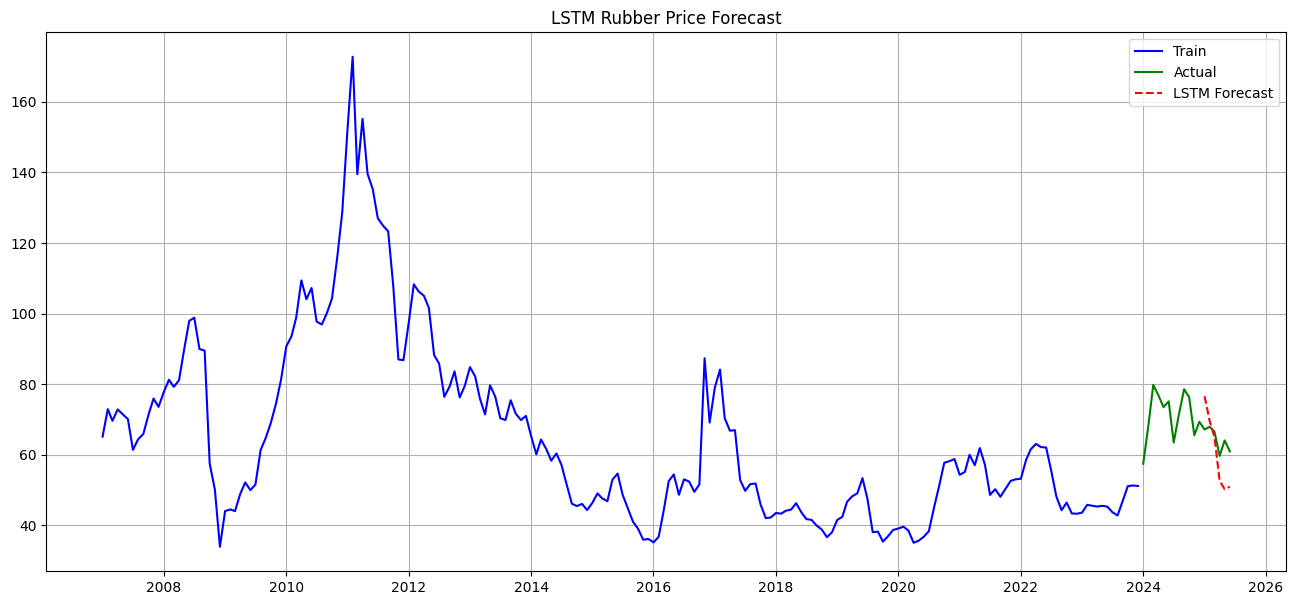

C:\Users\bankw\AppData\Local\Temp\ipykernel_29916\3420127646.py:68: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 0.85, 0.96])


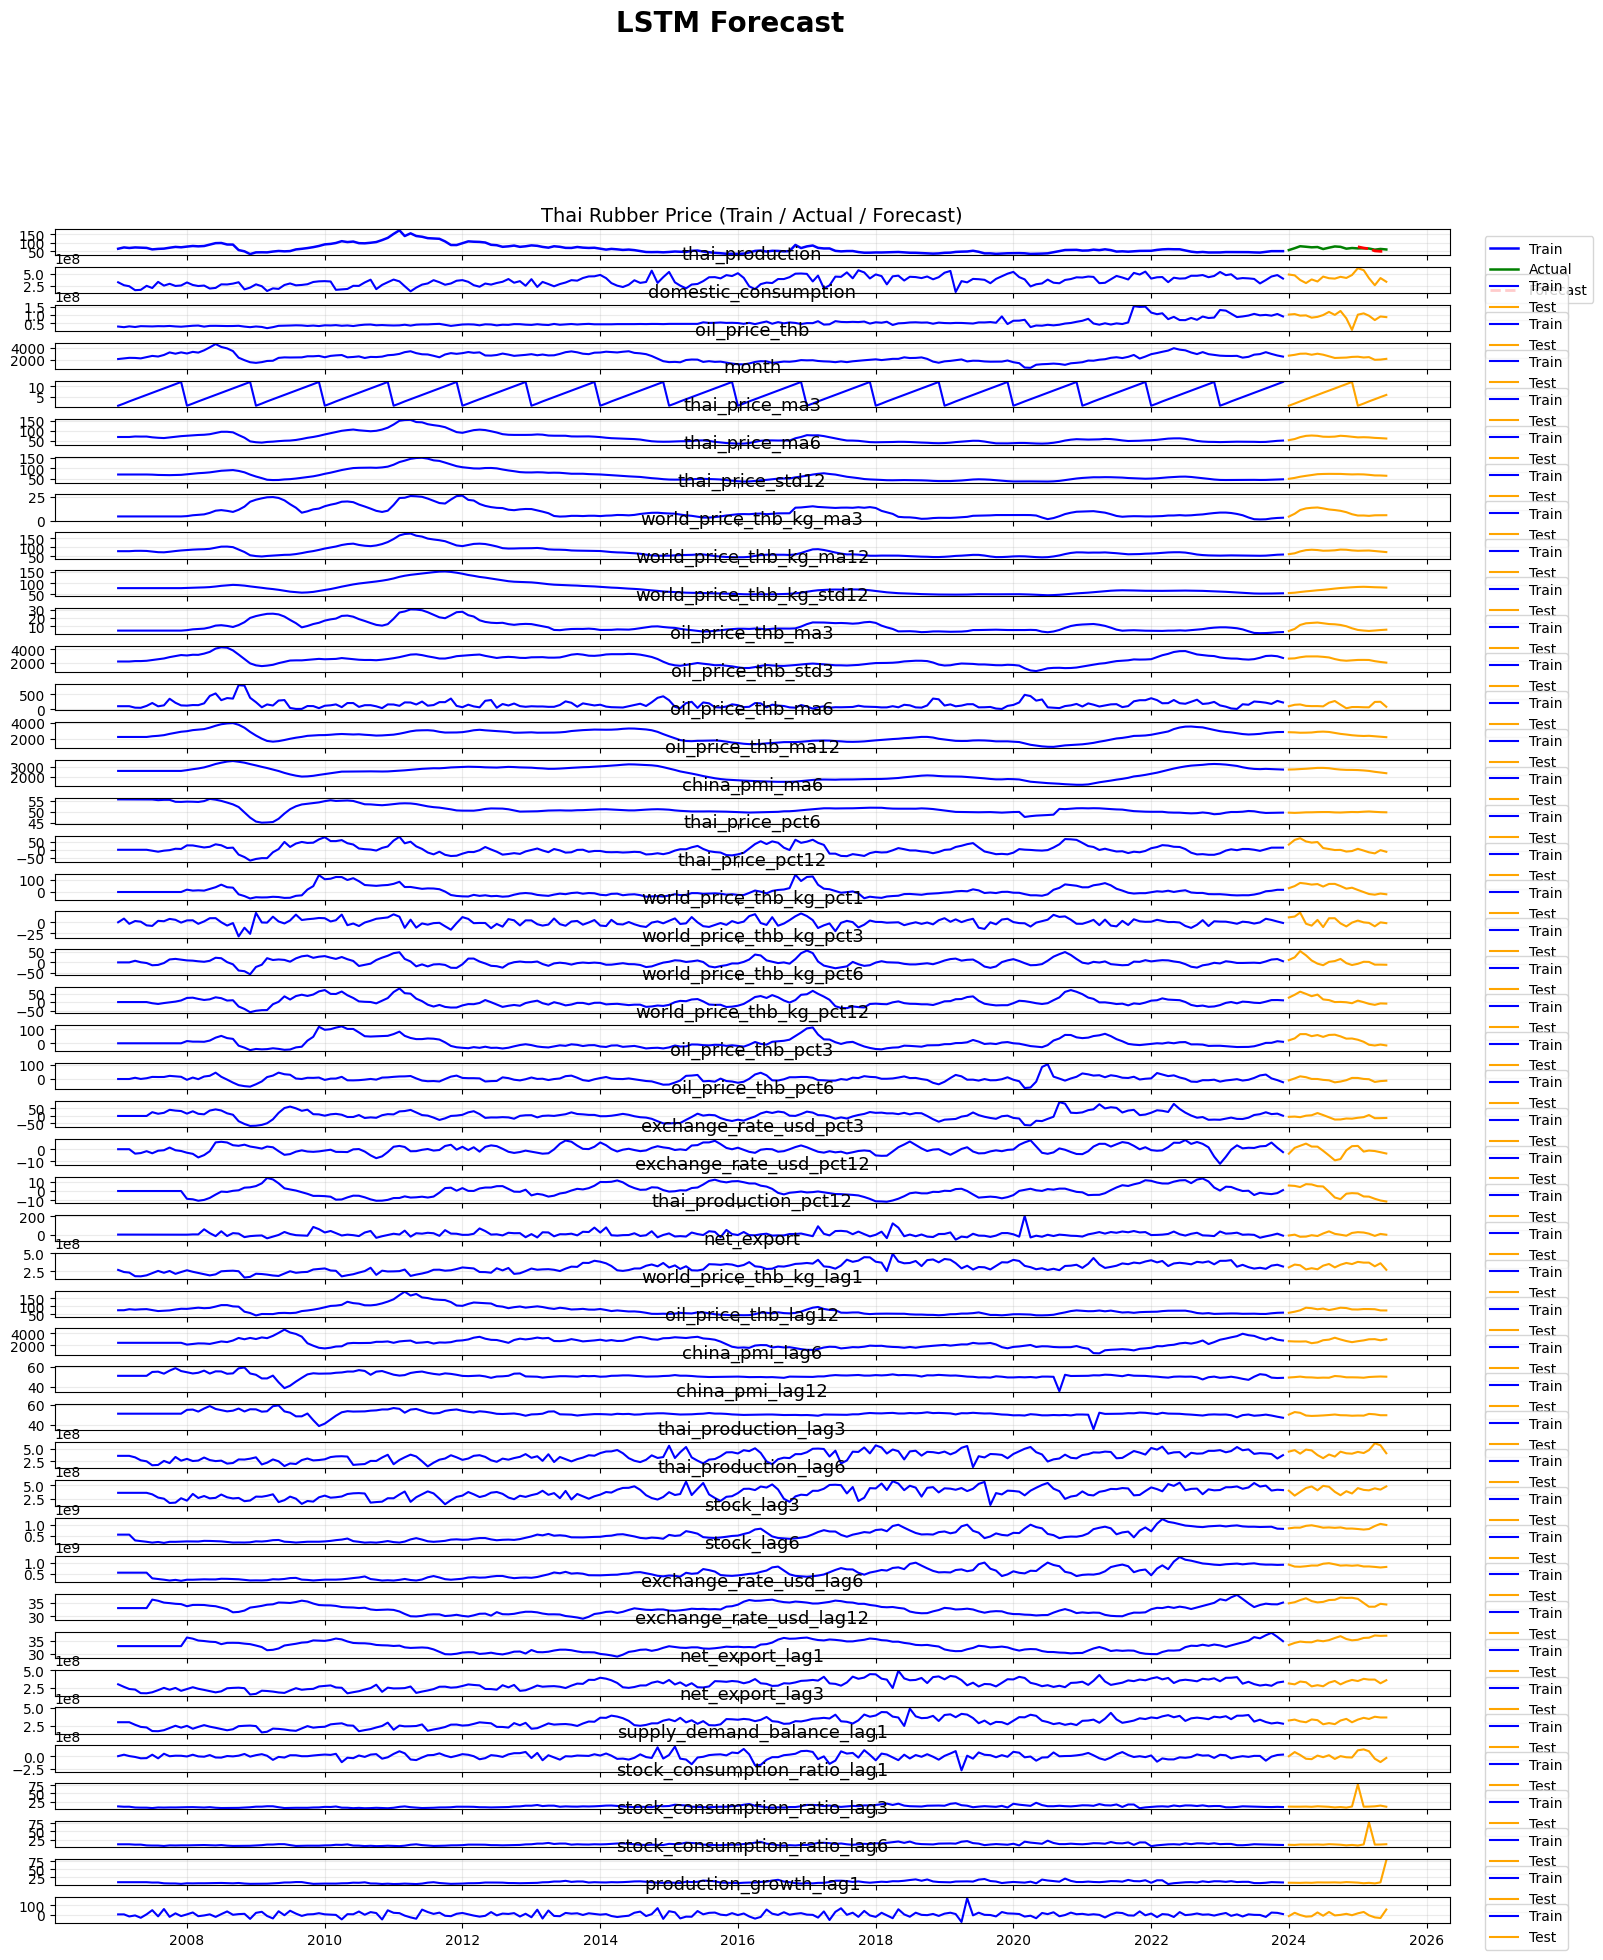

In [12]:
pred_after_index = test_data.index[-len(pred_after):]
actual_after = test_data['thai_price'].values

plt.figure(figsize=(16,7))

plt.plot(train_data.index, train_data['thai_price'], label='Train', color='blue')
plt.plot(test_data.index, actual_after, label='Actual', color='green')

plt.plot(pred_after_index, pred_after, label='LSTM Forecast', color='red', linestyle='--')

plt.title("LSTM Rubber Price Forecast")
plt.grid(True)
plt.legend()
plt.show()


# ปรับ layout ให้โปรขึ้น / ห่างกันมากขึ้น
fig, axes = plt.subplots(
    len(external_factors) + 1,
    1,
    figsize=(18, 22),
    sharex=True
)

fig.suptitle("LSTM Forecast", fontsize=20, fontweight='bold')
plt.subplots_adjust(hspace=0.45)

axes[0].plot(train_data.index,
             train_data['thai_price'],
             label='Train',
             color='blue',
             linewidth=1.8)

axes[0].plot(test_data.index,
             actual_after,
             color='green',
             label='Actual',
             linewidth=1.8)

axes[0].plot(pred_after_index,
             pred_after,
             color='red',
             label='Forecast',
             linestyle='--',
             linewidth=2.0)

axes[0].set_title("Thai Rubber Price (Train / Actual / Forecast)", fontsize=14)
axes[0].grid(True, alpha=0.25)
axes[0].legend(loc='upper left', bbox_to_anchor=(1.02, 1))

for i, fac in enumerate(external_factors):
    ax = axes[i + 1]
    ax.plot(train_data.index,
            train_data[fac],
            color='blue',
            label='Train',
            linewidth=1.5)
    ax.plot(test_data.index,
            test_data[fac],
            color='orange',
            label='Test',
            linewidth=1.5)

    ax.set_title(fac, fontsize=13)
    ax.grid(True, alpha=0.25)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

plt.tight_layout(rect=[0, 0, 0.85, 0.96])
plt.show()



In [13]:
def compute_score(rmse, mape, mean_trp, w_rmse=0.5, w_mape=0.5):
    """
    Unified Score 0–100 จาก RMSE และ MAPE
    """
    nrmse = rmse / mean_trp        # Normalize ด้วย mean ของ TRP
    mape_norm = mape / 100.0
    score = 100 * (1 - (w_rmse*nrmse + w_mape*mape_norm))
    return max(0, min(100, score))

score_before = compute_score(rmse_before, mape_before, mean_trp)
score_after  = compute_score(rmse_after,  mape_after,  mean_trp)

summary_df = pd.DataFrame({
    "Model": ["Before (Baseline Ridge)", "After (Optuna Ridge)"],
    "RMSE": [rmse_before, rmse_after],
    "MAPE (%)": [mape_before, mape_after],
    "Score (0-100)": [score_before, score_after]
})

print("=== COMPARISON: BEFORE vs AFTER (LSTM) ===")
print(summary_df.to_string(index=False))


=== COMPARISON: BEFORE vs AFTER (LSTM) ===
                  Model      RMSE  MAPE (%)  Score (0-100)
Before (Baseline Ridge) 11.635857 16.256297      82.862543
   After (Optuna Ridge)  8.507054 11.393572      87.716448


In [14]:
print("=== BEFORE MODEL (Baseline LSTM)===")
print("RMSE : ",f"{rmse_before:.4f}")
print("MAPE : ",f"{mape_before:.2f}%\n")

=== BEFORE MODEL (Baseline LSTM)===
RMSE :  11.6359
MAPE :  16.26%



PCA + LSTM

In [15]:
print("\nPCA + LSTM")

approach_pca_lstm = []

scaler2 = StandardScaler()
train_scaled2 = scaler2.fit_transform(train_exog)
test_scaled2  = scaler2.transform(test_exog)

def seq_lstm(data, win=12):
    X, y = [], []
    for i in range(len(data)-win):
        X.append(data[i:i+win,:])
        y.append(data[i+win,0])
    return np.array(X), np.array(y)


for n_comp in range(2,10):

    pca = PCA(n_components=n_comp)
    train_pca = pca.fit_transform(train_scaled2)
    test_pca  = pca.transform(test_scaled2)

    explained = pca.explained_variance_ratio_.sum()

    #full matrix TRP + PCs
    train_full = np.concatenate([train_data[['thai_price']].values, train_pca], axis=1)
    test_full  = np.concatenate([test_data[['thai_price']].values, test_pca], axis=1)

    Xtr, ytr = seq_lstm(train_full)
    Xte, yte = seq_lstm(test_full)

    mdl = Sequential([
        LSTM(64, activation='tanh', return_sequences=False,
             input_shape=(12, train_full.shape[1])),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    mdl.compile(optimizer='adam', loss='mse')

    es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    mdl.fit(
        Xtr, ytr,
        validation_split=0.1,
        epochs=100,
        batch_size=16,
        callbacks=[es],
        verbose=0
    )

    pred_unscaled = mdl.predict(Xte, verbose=0)

    # The model predicts unscaled TRP values, so no inverse transformation is needed.
    pred = pred_unscaled[:,0]

    rmse = np.sqrt(mean_squared_error(yte, pred))
    mape = mean_absolute_percentage_error(yte, pred)*100

    print(f"{n_comp} comp | Var={explained*100:.1f}% | RMSE={rmse:.4f} | MAPE={mape:.2f}%")

    approach_pca_lstm.append({
        "n_components": n_comp,
        "explained_var": explained,
        "RMSE": rmse,
        "MAPE": mape,
        "pred": pred,
        "true": yte
    })

best_pca_lstm = min(approach_pca_lstm, key=lambda x: x["RMSE"])

print("\n===== Best PCA+LSTM ====")
print("Components:", best_pca_lstm["n_components"])
print("Expl.Var :", best_pca_lstm["explained_var"]*100)
print("RMSE     :", best_pca_lstm["RMSE"])
print("MAPE     :", best_pca_lstm["MAPE"])


PCA + LSTM


c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2 comp | Var=41.5% | RMSE=16.7689 | MAPE=25.41%


c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3 comp | Var=49.6% | RMSE=18.4570 | MAPE=28.08%


c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4 comp | Var=55.9% | RMSE=18.1442 | MAPE=27.58%


c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5 comp | Var=61.4% | RMSE=5.9417 | MAPE=7.00%


c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6 comp | Var=65.6% | RMSE=15.0400 | MAPE=22.65%


c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7 comp | Var=69.8% | RMSE=19.3195 | MAPE=29.43%


c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8 comp | Var=73.3% | RMSE=16.1931 | MAPE=24.49%


c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9 comp | Var=76.3% | RMSE=15.4434 | MAPE=23.30%

===== Best PCA+LSTM ====
Components: 5
Expl.Var : 61.366750548571204
RMSE     : 5.941715924080203
MAPE     : 6.99584172701163


In [16]:
print("\nPCA + LSTM")

approach_pca_lstm = []

scaler2 = StandardScaler()
train_scaled2 = scaler2.fit_transform(train_exog)
test_scaled2  = scaler2.transform(test_exog)

def seq_lstm(data, win=12):
    X, y = [], []
    for i in range(len(data)-win):
        X.append(data[i:i+win,:])
        y.append(data[i+win,0])
    return np.array(X), np.array(y)


for n_comp in range(2,10):

    pca = PCA(n_components=n_comp)
    train_pca = pca.fit_transform(train_scaled2)
    test_pca  = pca.transform(test_scaled2)

    explained = pca.explained_variance_ratio_.sum()

    # full matrix TRP + PCs
    train_full = np.concatenate([train_data[['thai_price']].values, train_pca], axis=1)
    test_full  = np.concatenate([test_data[['thai_price']].values, test_pca], axis=1)

    Xtr, ytr = seq_lstm(train_full)
    Xte, yte = seq_lstm(test_full)

    mdl = Sequential([
        LSTM(64, activation='tanh', return_sequences=False,
             input_shape=(12, train_full.shape[1])),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    mdl.compile(optimizer='adam', loss='mse')

    es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    mdl.fit(
        Xtr, ytr,
        validation_split=0.1,
        epochs=100,
        batch_size=16,
        callbacks=[es],
        verbose=0
    )

    pred_unscaled = mdl.predict(Xte, verbose=0)

    # The model predicts unscaled TRP values, so no inverse transformation is needed.
    pred = pred_unscaled[:,0]

    rmse = np.sqrt(mean_squared_error(yte, pred))
    mape = mean_absolute_percentage_error(yte, pred)*100

    print(f"{n_comp} comp | Var={explained*100:.1f}% | RMSE={rmse:.4f} | MAPE={mape:.2f}%")

    approach_pca_lstm.append({
        "n_components": n_comp,
        "explained_var": explained,
        "RMSE": rmse,
        "MAPE": mape,
        "pred": pred,
        "true": yte
    })

# เลือกตัวที่ RMSE ต่ำสุด
best_pca_lstm = min(approach_pca_lstm, key=lambda x: x["RMSE"])

print("\n===== Best PCA+LSTM (by RMSE) =====")
print("Best params:")
print(f"  n_components      = {best_pca_lstm['n_components']}")
print(f"  explained_var (%) = {best_pca_lstm['explained_var']*100:.2f}%")
print("\nPerformance:")
print(f"  RMSE              = {best_pca_lstm['RMSE']:.4f}")
print(f"  MAPE (%)          = {best_pca_lstm['MAPE']:.2f}%")

# =========================
# ตารางสรุปผลแบบภาพด้านบน
# =========================

# คำนวน Accuracy เช่นเดียวกับก่อนหน้า
def compute_score(rmse, mape, mean_trp, w_rmse=0.5, w_mape=0.5):
    nrmse = rmse / mean_trp        
    mape_norm = mape / 100.0
    score = 100 * (1 - (w_rmse*nrmse + w_mape*mape_norm))
    return max(0, min(100, score))

baseline_rmse = rmse_before        # จากโมเดล LSTM ก่อน PCA
baseline_mape = mape_before
baseline_acc  = compute_score(baseline_rmse, baseline_mape, mean_trp)

best_rmse = best_pca_lstm["RMSE"]
best_mape = best_pca_lstm["MAPE"]
best_acc  = compute_score(best_rmse, best_mape, mean_trp)

summary_df = pd.DataFrame({
    "Model": ["Baseline LSTM", f"PCA+LSTM ({best_pca_lstm['n_components']} comp)"],
    "RMSE": [baseline_rmse, best_rmse],
    "MAPE (%)": [f"{baseline_mape:.2f}%", f"{best_mape:.2f}%"],
    "ACCURACY (%)": [f"{baseline_acc:.2f}%", f"{best_acc:.2f}%"]
})

print("\nPerformance Comparison\n")
print(summary_df.to_string(index=True, col_space=15))




PCA + LSTM


c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2 comp | Var=41.5% | RMSE=3.7425 | MAPE=3.71%


c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3 comp | Var=49.6% | RMSE=6.2959 | MAPE=8.33%


c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4 comp | Var=55.9% | RMSE=18.5044 | MAPE=28.15%


c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5 comp | Var=61.4% | RMSE=6.1823 | MAPE=7.80%


c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6 comp | Var=65.6% | RMSE=15.0026 | MAPE=22.60%


c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7 comp | Var=69.8% | RMSE=18.1845 | MAPE=27.63%


c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8 comp | Var=73.3% | RMSE=16.3922 | MAPE=24.81%


c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9 comp | Var=76.3% | RMSE=14.8085 | MAPE=22.29%

===== Best PCA+LSTM (by RMSE) =====
Best params:
  n_components      = 2
  explained_var (%) = 41.46%

Performance:
  RMSE              = 3.7425
  MAPE (%)          = 3.71%

Performance Comparison

                             Model            RMSE        MAPE (%)    ACCURACY (%)
0                    Baseline LSTM       11.635857          16.26%          82.86%
1                PCA+LSTM (2 comp)        3.742473           3.71%          95.25%


Data Visualization

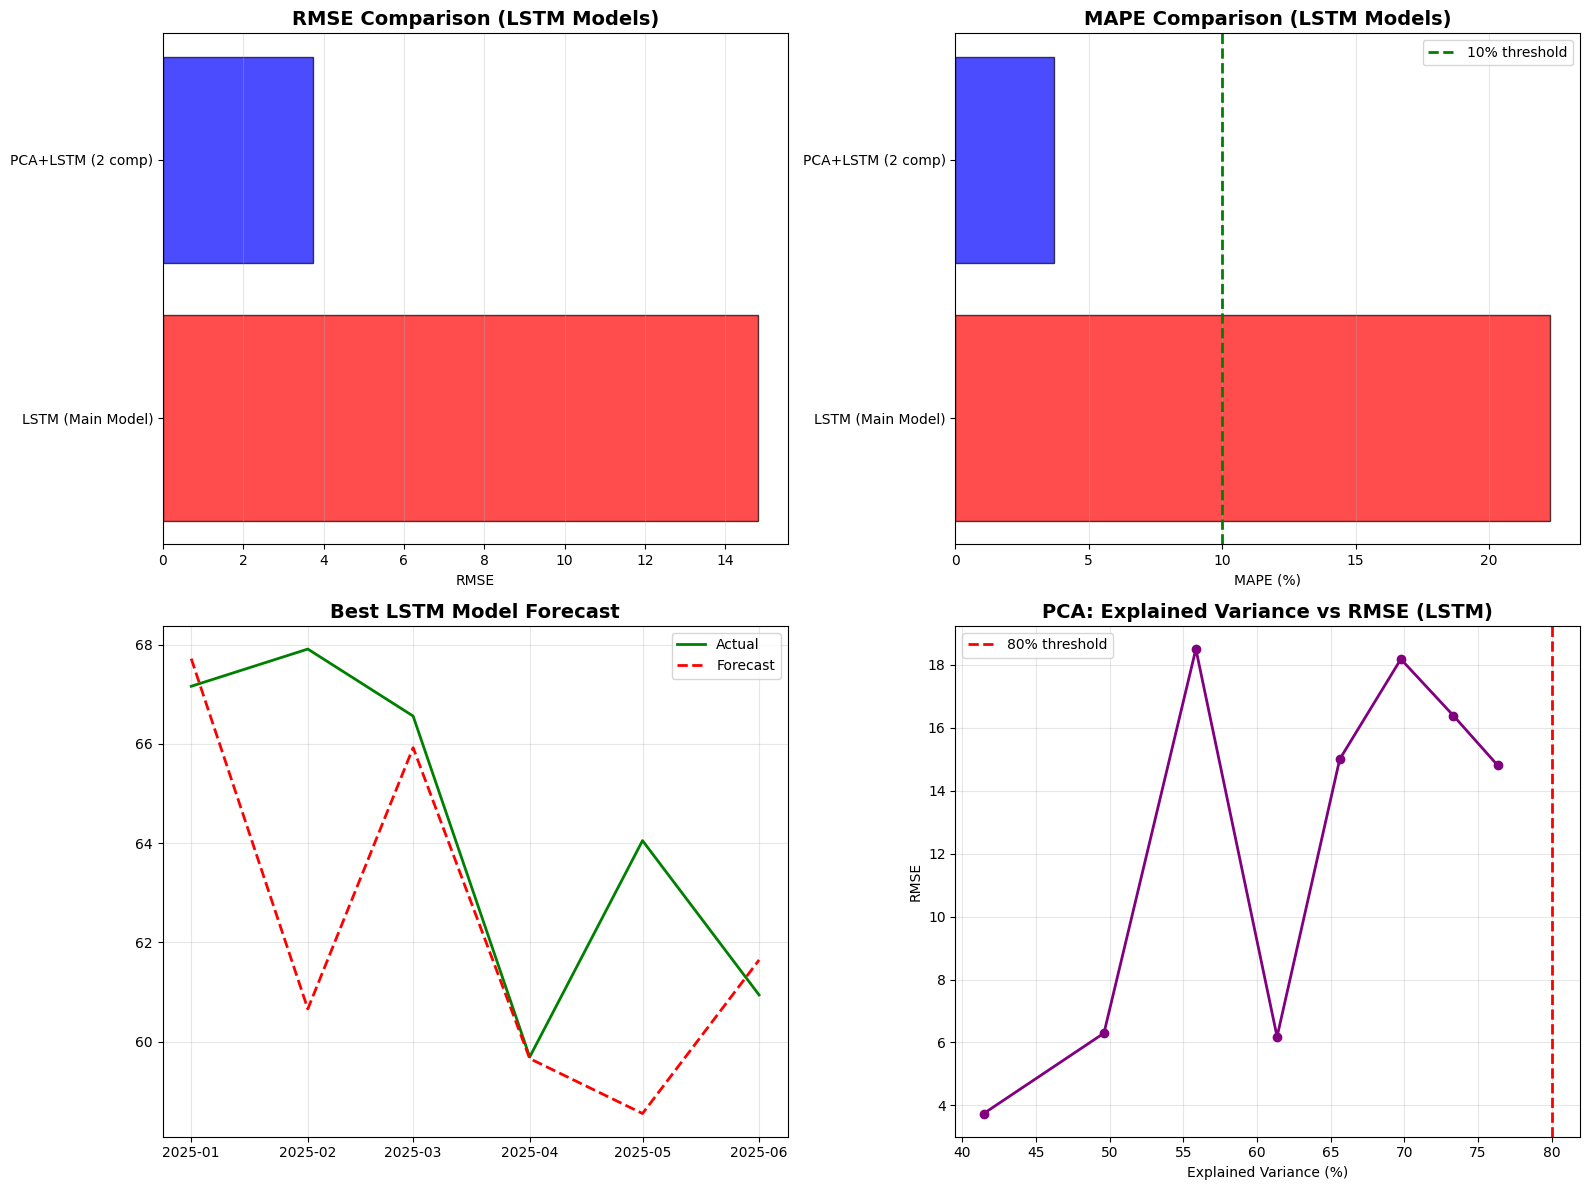

In [17]:
import matplotlib.pyplot as plt

#เทียบเฉพาะ LSTM Main + PCA+LSTM
all_approaches = [
    {
        "Method": "LSTM (Main Model)",
        "RMSE": rmse,
        "MAPE": mape
    },
    {
        "Method": f"PCA+LSTM ({best_pca_lstm['n_components']} comp)",
        "RMSE": best_pca_lstm['RMSE'],
        "MAPE": best_pca_lstm['MAPE']
    }
]

methods = [a["Method"] for a in all_approaches]
rmse_vals = [a["RMSE"] for a in all_approaches]
mape_vals = [a["MAPE"] for a in all_approaches]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

#RMSE Comparison
ax = axes[0, 0]
ax.barh(methods, rmse_vals, color=['red', 'blue'], alpha=0.7, edgecolor='black')
ax.set_title("RMSE Comparison (LSTM Models)", fontsize=14, fontweight='bold')
ax.set_xlabel("RMSE")
ax.grid(True, axis='x', alpha=0.3)


#MAPE Comparison
ax = axes[0, 1]
ax.barh(methods, mape_vals, color=['red', 'blue'], alpha=0.7, edgecolor='black')
ax.axvline(x=10, color='green', linestyle='--', linewidth=2, label='10% threshold')
ax.set_title("MAPE Comparison (LSTM Models)", fontsize=14, fontweight='bold')
ax.set_xlabel("MAPE (%)")
ax.legend()
ax.grid(True, axis='x', alpha=0.3)

#Best Model Forecast
best_overall = (
    best_pca_lstm
    if best_pca_lstm["RMSE"] < rmse
    else {"pred": pred, "true": actual}
)

ax = axes[1, 0]
#กรณีเป็น PCA+LSTM
if "true" in best_overall:
    ax.plot(
        test_data.index[WINDOW:],
        best_overall["true"],
        label="Actual",
        color="green",
        linewidth=2
    )
    ax.plot(
        test_data.index[WINDOW:],
        best_overall["pred"],
        label="Forecast",
        color="red",
        linestyle="--",
        linewidth=2
    )
else:
    #ถ้าเป็น main LSTM
    ax.plot(
        test_data.index[WINDOW:], actual, label='Actual', color='green', linewidth=2)
    ax.plot(
        test_data.index[WINDOW:], pred, label='Forecast', color='red', linestyle='--', linewidth=2)

ax.set_title("Best LSTM Model Forecast", fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend()

#PCA vs RMSE Curve
ax = axes[1, 1]
exp_vars = [r['explained_var']*100 for r in approach_pca_lstm]
rmse_vals_pca = [r['RMSE'] for r in approach_pca_lstm]

ax.plot(exp_vars, rmse_vals_pca, marker='o', color='purple', linewidth=2)
ax.axvline(x=80, linestyle='--', color='red', linewidth=2, label='80% threshold')

ax.set_xlabel("Explained Variance (%)")
ax.set_ylabel("RMSE")
ax.set_title("PCA: Explained Variance vs RMSE (LSTM)", fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

In [18]:
data = {
    'Model': ['Baseline (LSTM)', 'Optuna LSTM'],
    'RMSE': [rmse_before, rmse_after],
    'MAPE': [mape_before/100, mape_after/100],
    'ACCURACY': [score_before/100, score_after/100]
}

df_comparison = pd.DataFrame(data)

df_comparison['MAPE (%)'] = (df_comparison['MAPE'] * 100).map('{:.2f}%'.format)
df_comparison['ACCURACY (%)'] = (df_comparison['ACCURACY'] * 100).map('{:.2f}%'.format)

df_display = df_comparison[['Model', 'RMSE', 'MAPE (%)', 'ACCURACY (%)']]

print("Performance Comparison (LSTM)\n")
print(df_display.to_string(index=True, col_space=15))

Performance Comparison (LSTM)

                           Model            RMSE        MAPE (%)    ACCURACY (%)
0                Baseline (LSTM)       11.635857          16.26%          82.86%
1                    Optuna LSTM        8.507054          11.39%          87.72%


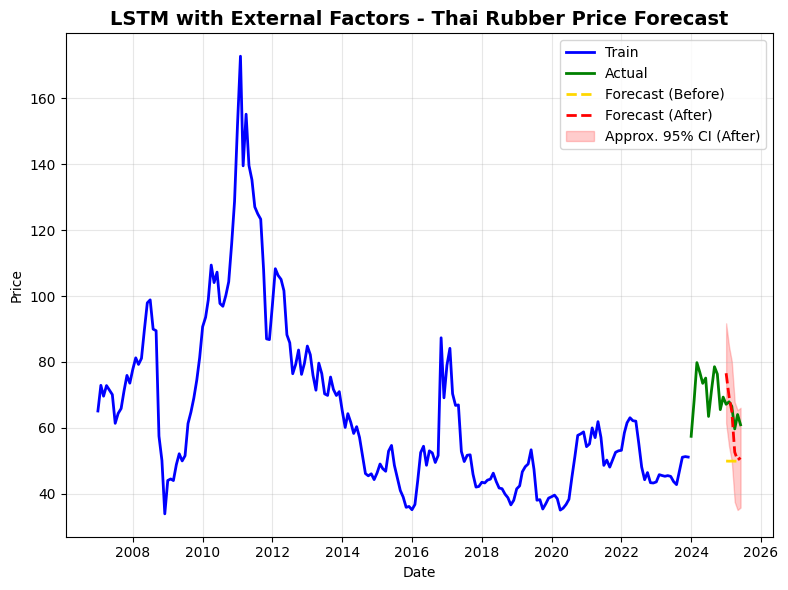

In [19]:
# %% [markdown]
# Final Plot – Compare Baseline vs Optuna LSTM (แบบรูปด้านบน)

# %%
# จัด index กับค่าให้ตรงกัน (ใช้ช่วง test ที่เหลือหลัง WINDOW)
test_idx_aligned = test_data.index[WINDOW:]
actual_test = test_data['thai_price'].iloc[WINDOW:].values

# Forecast ก่อนปรับ (Baseline LSTM)
forecast_before = np.asarray(pred)[:len(actual_test)]

# Forecast หลัง Optuna (Optuna LSTM)
forecast_after = np.asarray(pred_after)[:len(actual_test)]

# คำนวณ approx. 95% CI จาก residual ของโมเดลหลังปรับ
residuals_after = actual_test - forecast_after
sigma = residuals_after.std()
ci_upper = forecast_after + 1.96 * sigma
ci_lower = forecast_after - 1.96 * sigma

plt.figure(figsize=(8, 6))

# Train
plt.plot(train_data.index,
         train_data['thai_price'],
         label='Train',
         color='blue',
         linewidth=2)

# Actual (Test ทั้งช่วง)
plt.plot(test_data.index,
         test_data['thai_price'],
         label='Actual',
         color='green',
         linewidth=2)

# Forecast ก่อนปรับ
plt.plot(test_idx_aligned,
         forecast_before,
         label='Forecast (Before)',
         color='gold',
         linestyle='--',
         linewidth=2)

# Forecast หลังปรับ
plt.plot(test_idx_aligned,
         forecast_after,
         label='Forecast (After)',
         color='red',
         linestyle='--',
         linewidth=2)

# Approx. 95% CI ของโมเดลหลังปรับ
plt.fill_between(test_idx_aligned,
                 ci_lower,
                 ci_upper,
                 color='red',
                 alpha=0.2,
                 label='Approx. 95% CI (After)')

plt.title("LSTM with External Factors - Thai Rubber Price Forecast",
          fontsize=14,
          fontweight='bold')
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True, alpha=0.3)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()
